<a href="https://colab.research.google.com/github/MasahiroAraki/MachineLearning/blob/master/Python/chap06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第6章

教科書で取り上げた boston データは差別的な属性が含まれており、倫理的な問題があるとして scikit-learn ver1.2で削除されました。

回帰用の toy data としては、代わりに [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) を使うことが推奨されています。

California housing データはブロックグループ内の収入の中央値、平均部屋数、平均世帯人数、緯度、経度などと不動産価格の関係を示したものです。このデータを用いて線形回帰と正則化、回帰木について学びます。


In [ ]:
#出力を小数点以下3桁に制限。DataFrame内では設定は無効
%precision 3

'%.3f'

## 線形回帰

必要なライブラリを読み込みます。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

### データの読み込み

dataをX、targetをyに格納した後、DESCR属性を表示します。

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X = housing.data
y = housing.target
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

np.set_printoptions(suppress=True)  として、ndarrayのデータを表示させたときに指数表示を行わないようにしてから、学習データXの冒頭5件ほどの内容を確認します。

In [ ]:
np.set_printoptions(suppress=True)
X[0:5]

array([[   8.325,   41.   ,    6.984,    1.024,  322.   ,    2.556,
          37.88 , -122.23 ],
       [   8.301,   21.   ,    6.238,    0.972, 2401.   ,    2.11 ,
          37.86 , -122.22 ],
       [   7.257,   52.   ,    8.288,    1.073,  496.   ,    2.802,
          37.85 , -122.24 ],
       [   5.643,   52.   ,    5.817,    1.073,  558.   ,    2.548,
          37.85 , -122.25 ],
       [   3.846,   52.   ,    6.282,    1.081,  565.   ,    2.181,
          37.85 , -122.25 ]])

In [ ]:
y[0:5]

array([4.526, 3.585, 3.521, 3.413, 3.422])

特徴のスケールがかなり異なるので、標準化しておきます。

In [ ]:
ss = StandardScaler()
X = ss.fit_transform(X)

組み込みデータセットの特徴名はfeature_names属性の値として文字列配列の形式で得られます。回帰式の解釈に必要になるので確認しておきます。

In [ ]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

[LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)で線形回帰関数の学習を行います。

In [ ]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

係数と係数の二乗和を表示します。

In [ ]:
for f, w in zip(housing.feature_names, lr.coef_) :
    print(f"{f:7s}: {w:6.2f}")

MedInc :   0.83
HouseAge:   0.12
AveRooms:  -0.27
AveBedrms:   0.31
Population:  -0.00
AveOccup:  -0.04
Latitude:  -0.90
Longitude:  -0.87


In [ ]:
sum(lr.coef_**2) #係数の二乗和

2.4355275134214622

### 評価

交差確認による[決定係数](http://mathtrain.jp/ketteikeisu)を用いた評価を行います。評価法はcross_val_scoreメソッドのscoring引数で決定係数を指定します。scoring引数の可能な値は[こちら](http://scikit-learn.org/stable/modules/model_evaluation.html)。また、交差確認における分割をランダムにするため、[ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)を使います。


In [ ]:
cv = ShuffleSplit(n_splits=10)
scores = cross_val_score(lr, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.59 (+/- 0.02)


## 正則化

[Ridge回帰(L2)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
のパラメータalphaの値でL2正則化項の重みを調整することで、汎化性能が上がる可能性があります。

In [ ]:
lr2 = Ridge(alpha=10.0)
lr2.fit(X, y)

Ridge(alpha=10.0)

係数と係数の二乗和を表示します。

In [ ]:
for f, w in zip(housing.feature_names, lr2.coef_) :
    print(f"{f:7s}: {w:6.2f}")

MedInc :   0.83
HouseAge:   0.12
AveRooms:  -0.26
AveBedrms:   0.30
Population:  -0.00
AveOccup:  -0.04
Latitude:  -0.89
Longitude:  -0.86


In [ ]:
sum(lr2.coef_**2)

2.4117034314535477

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(lr2, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.60 (+/- 0.02)


[Lasso回帰(L1)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
のパラメータalphaの値を大きくすれば、L1正則化項の重みが大きくなり、重みが0となる次元が増えます。

In [ ]:
lr3 = Lasso(alpha=0.05)
lr3.fit(X, y)

Lasso(alpha=0.05)

係数と係数の二乗和を表示します。

In [ ]:
for f, w in zip(housing.feature_names, lr3.coef_) :
    print(f"{f:7s}: {w:6.2f}")

MedInc :   0.74
HouseAge:   0.14
AveRooms:  -0.00
AveBedrms:   0.00
Population:   0.00
AveOccup:  -0.00
Latitude:  -0.26
Longitude:  -0.22


In [ ]:
sum(lr3.coef_**2)

0.6761562395962673

結果に影響の大きい特徴をリストアップ

In [ ]:
np.array(housing.feature_names)[abs(lr3.coef_) > 0.1]

array(['MedInc', 'HouseAge', 'Latitude', 'Longitude'], dtype='<U10')

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(lr3, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.54 (+/- 0.01)


## 回帰木

回帰木の作成。深さは3にしておきます。

In [ ]:
rt = DecisionTreeRegressor(max_depth = 3)
rt.fit(X, y)

DecisionTreeRegressor(max_depth=3)

木の表示を行います。ノードの色の濃さはそのノードに割り当てられた出力値の平均を反映しています。

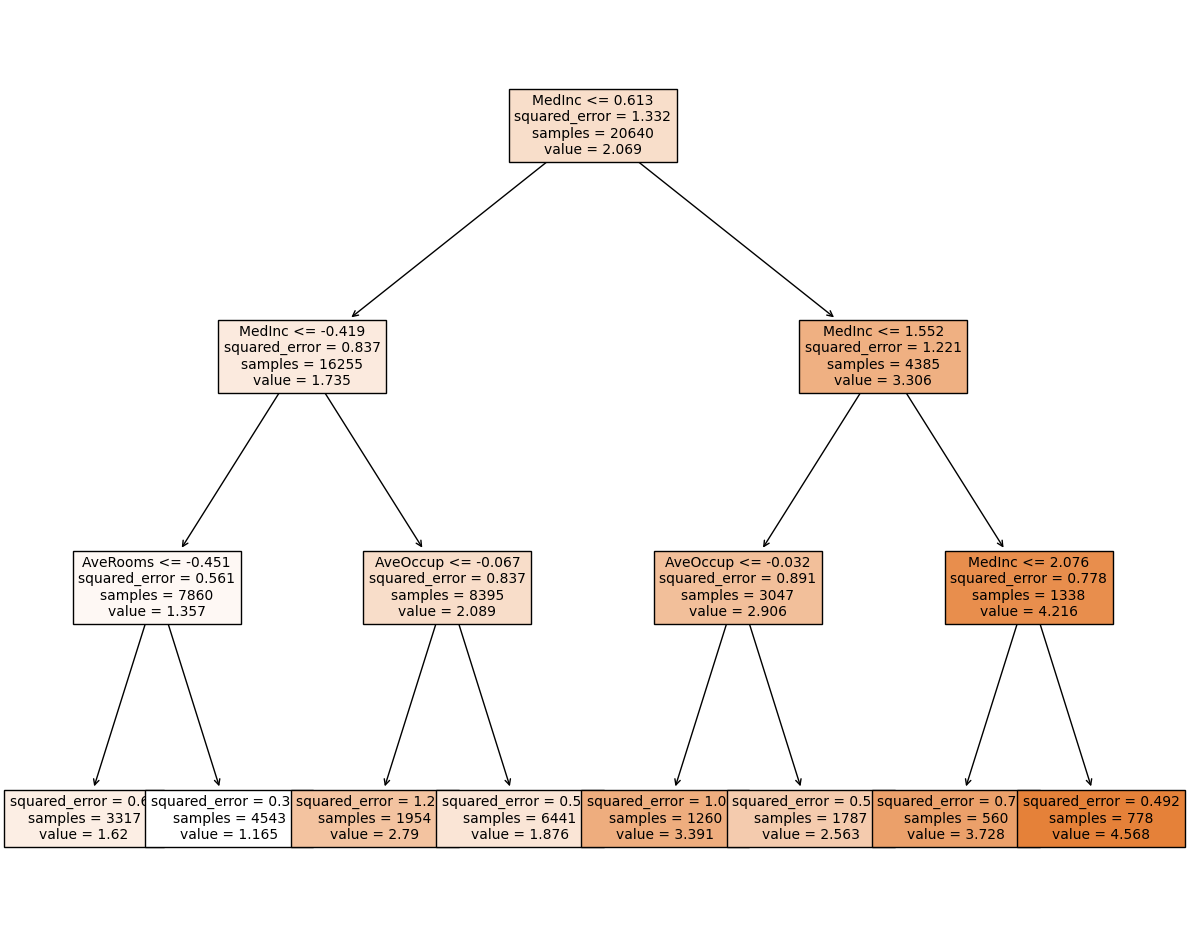

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(rt, filled=True, feature_names=housing.feature_names, fontsize=10)
plt.show()

### 評価

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(rt, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.53 (+/- 0.02)


### ハイパーパラメータの変更

木を浅くしてみます。

In [ ]:
rt2 = DecisionTreeRegressor(max_depth = 2)
rt2.fit(X,y)

DecisionTreeRegressor(max_depth=2)

木の表示

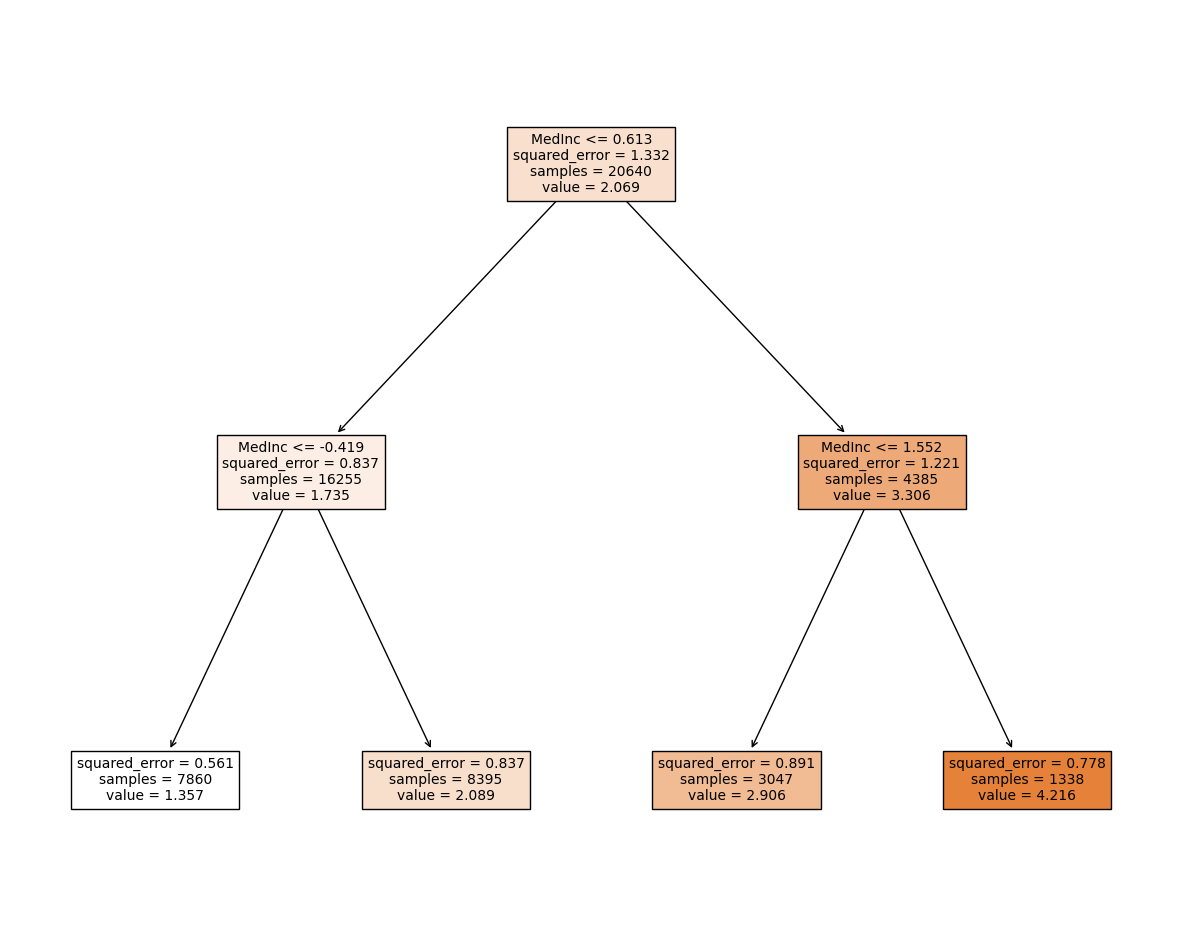

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(rt2, filled=True, feature_names=housing.feature_names, fontsize=10)
plt.show()

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(rt2, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.43 (+/- 0.02)


木を深くしてみます。

In [ ]:
rt3 = DecisionTreeRegressor(max_depth = 6)
rt3.fit(X,y)

DecisionTreeRegressor(max_depth=6)

木の表示

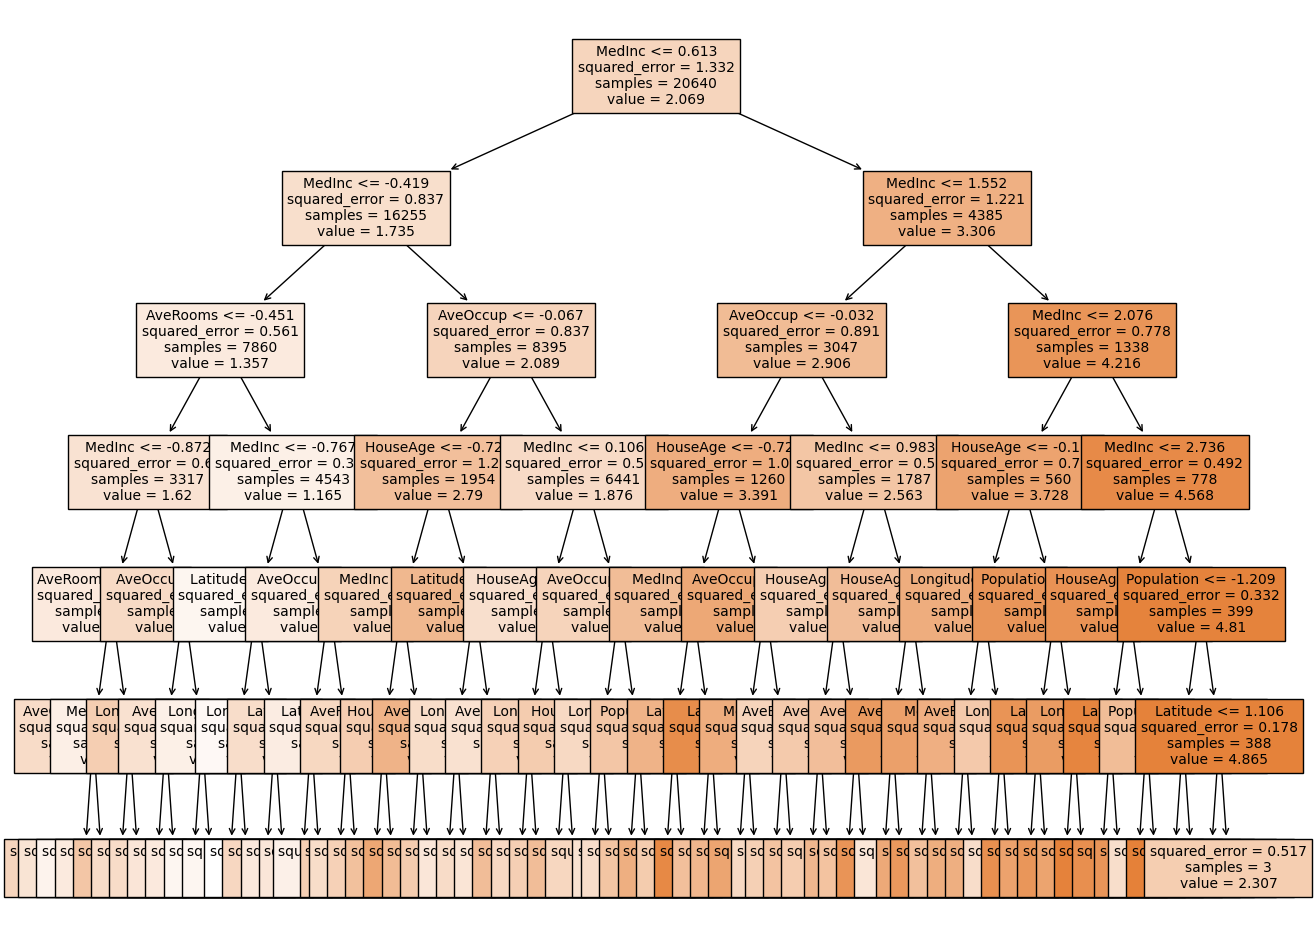

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(rt3, filled=True, feature_names=housing.feature_names, fontsize=10)
plt.show()

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(rt3, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.65 (+/- 0.02)


二乗誤差の値を見ると、深い木の方が性能が高くなっています。これはこのデータのみに言えることで、一般化はできません。

# 演習問題

scikit-learn付属のdiabetesデータに対して、なるべく性能の高い回帰モデルを求めてください。また、評価は一つ抜き法で行ってください。

## 解答例

## 線形回帰

必要なライブラリを読み込みます。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

### データの読み込み

In [ ]:
diabetes = load_diabetes(as_frame=True)
print(diabetes.DESCR)
X = diabetes.data
y = diabetes.target

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [ ]:
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


組み込みデータセットの特徴名はfeature_names属性の値として文字列配列の形式で得られます。回帰式の解釈に必要になるので確認しておきます。

In [ ]:
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

### 評価

交差確認による[決定係数](http://mathtrain.jp/ketteikeisu)を用いた評価を行います。cross_val_scoreメソッドのscoring引数で決定係数を指定します。scoring引数の可能な値は[こちら](http://scikit-learn.org/stable/modules/model_evaluation.html)。また、交差確認における分割をランダムにするため、[ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)を使い、[LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)で線形回帰関数の学習を行います。

何度かセルを実行してみると、評価値が比較的大きく変動することがわかります。回帰問題では、データ分割の違いによる学習結果の影響が大きいようです。

In [ ]:
cv = ShuffleSplit(n_splits=10)
lr = LinearRegression()
scores = cross_val_score(lr, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.46 (+/- 0.12)


ひとつ抜き方による評価は二乗誤差の平均の負数を用います。評価用のデータが1つなので、相関係数が求められないからです。こちらはランダム性はないので、分散を求める必要はありません。

In [ ]:
cv2 = LeaveOneOut()
scores = cross_val_score(lr, X, y, cv=cv2, scoring='neg_mean_squared_error')
print(f"{scores.mean():.2f}")

-3001.75


## 正則化

[Ridge回帰(L2)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
のパラメータalphaの値でL2正則化項の重みを調整することで、汎化性能が上がる可能性があります。

In [ ]:
lr2 = Ridge(alpha=0.001)
scores = cross_val_score(lr2, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.50 (+/- 0.07)


ひとつ抜き方による二乗誤差を用いた評価

In [ ]:
scores = cross_val_score(lr2, X, y, cv=cv2, scoring='neg_mean_squared_error')
print(f"{scores.mean():.2f}")

-3000.66


[Lasso回帰(L1)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
のパラメータalphaの値を大きくすれば、L1正則化項の重みが大きくなり、重みが0となる次元が増えます。

In [ ]:
lr3 = Lasso(alpha=0.05)
scores = cross_val_score(lr3, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.46 (+/- 0.08)


ひとつ抜き方による二乗誤差を用いた評価

In [ ]:
scores = cross_val_score(lr3, X, y, cv=cv2, scoring='neg_mean_squared_error')
print(f"{scores.mean():.2f}")

-2993.76


## 回帰木

回帰木の作成。深さは3にしておきます。

In [ ]:
rt = DecisionTreeRegressor(max_depth = 3)
rt.fit(X, y)

DecisionTreeRegressor(max_depth=3)

木の表示

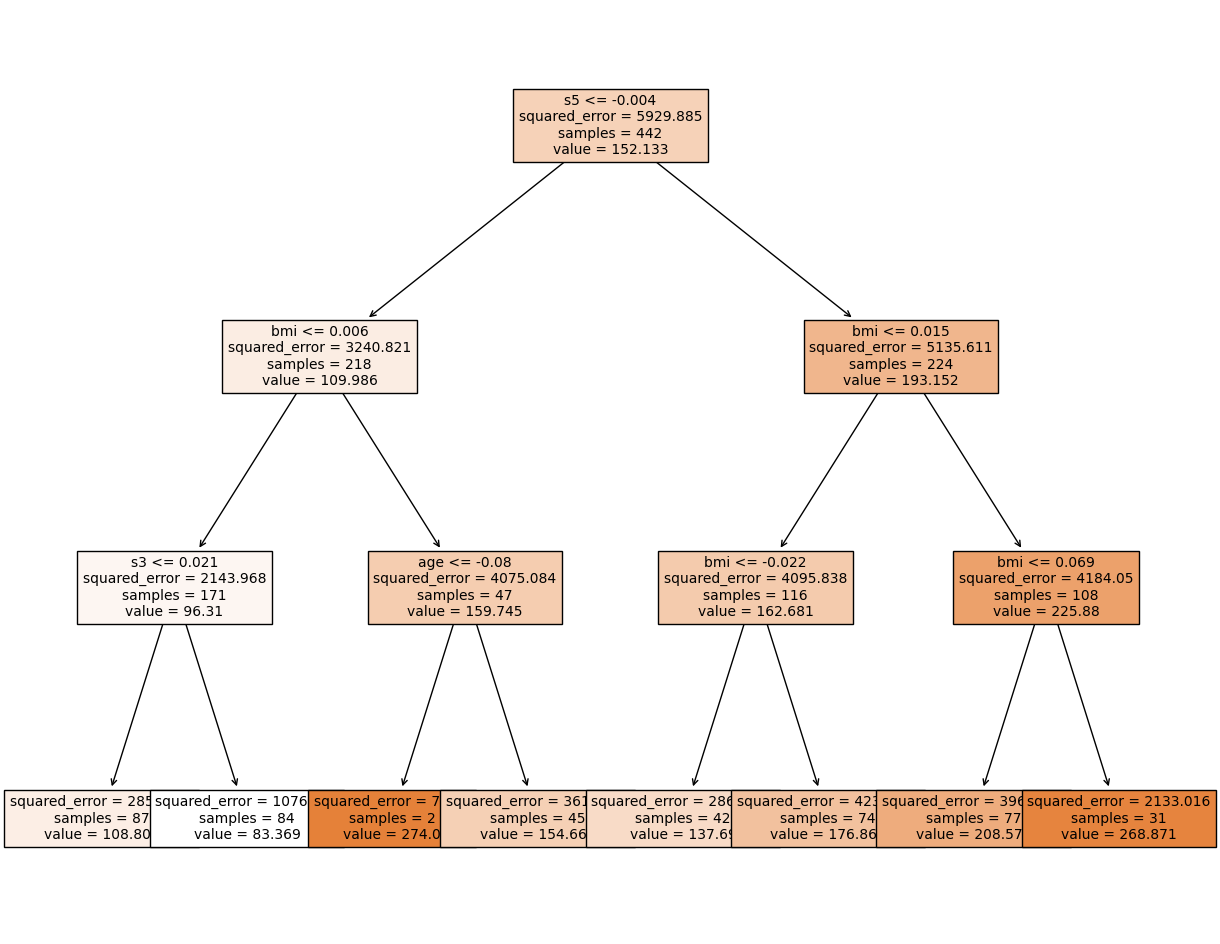

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(rt, filled=True, feature_names=diabetes.feature_names, fontsize=10)
plt.show()

### 評価

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(rt, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.28 (+/- 0.12)


ひとつ抜き方による二乗誤差を用いた評価

In [ ]:
scores = cross_val_score(rt, X, y, cv=cv2, scoring='neg_mean_squared_error')
print(f"{scores.mean():.2f}")

-3542.26


### ハイパーパラメータの変更

木を浅くしてみます。

In [ ]:
rt2 = DecisionTreeRegressor(max_depth = 2)
rt2.fit(X, y)

DecisionTreeRegressor(max_depth=2)

木の表示

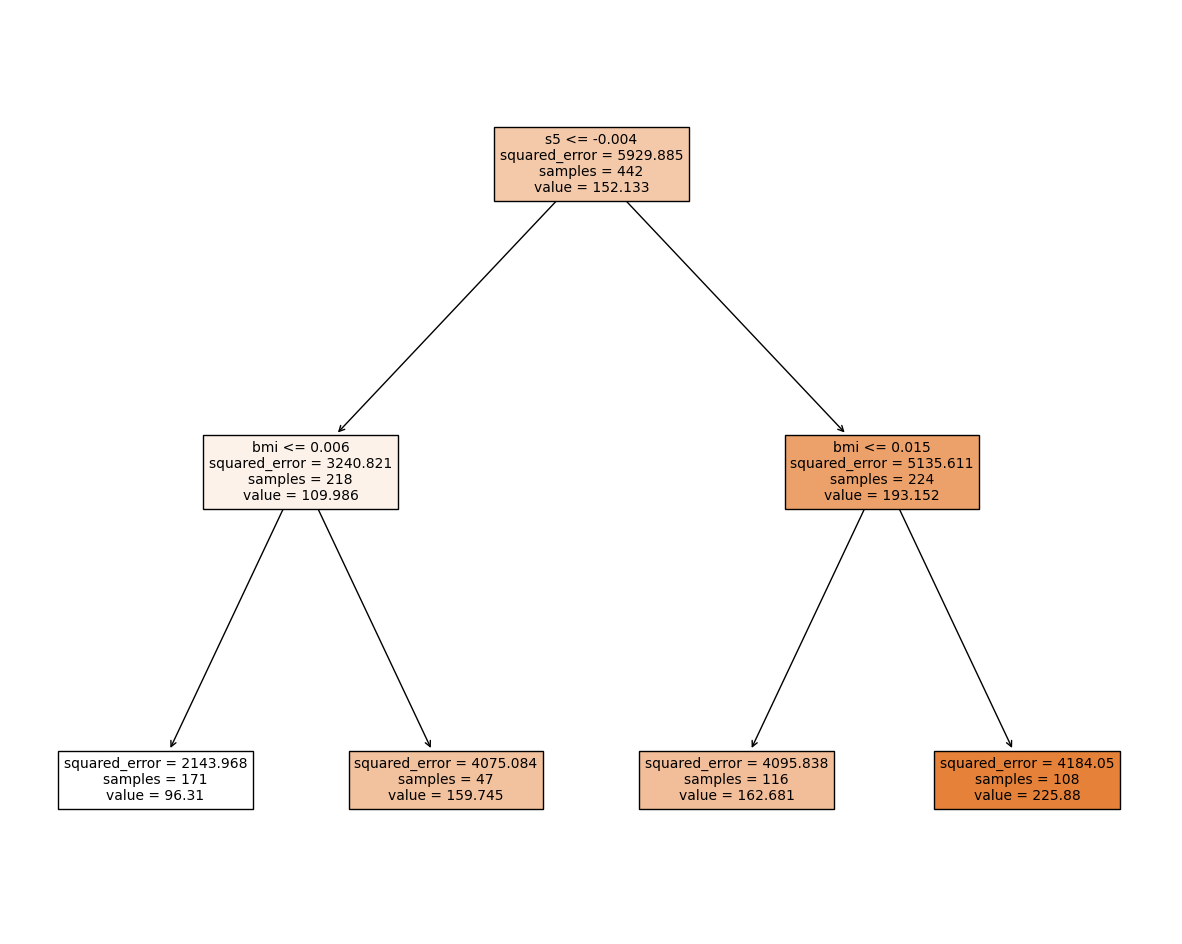

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(rt2, filled=True, feature_names=diabetes.feature_names, fontsize=10)
plt.show()

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(rt2, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.26 (+/- 0.14)


ひとつ抜き方による二乗誤差を用いた評価

In [ ]:
scores = cross_val_score(rt2, X, y, cv=cv2, scoring='neg_mean_squared_error')
print(f"{scores.mean():.2f}")

-3554.94


木を深くしてみます。

In [ ]:
rt3 = DecisionTreeRegressor(max_depth = 6)
rt3.fit(X, y)

DecisionTreeRegressor(max_depth=6)

木の表示

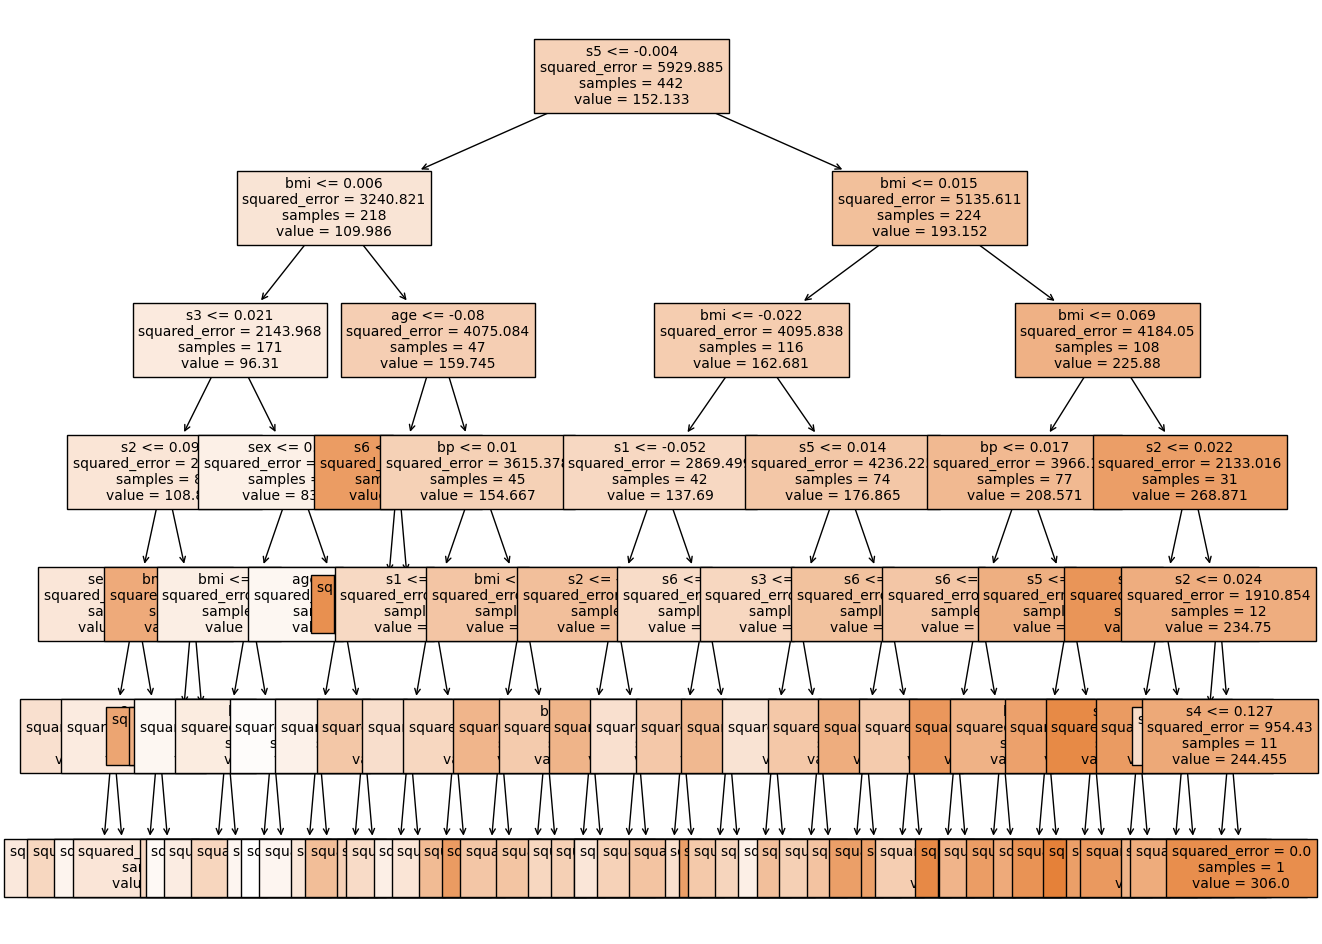

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(rt3, filled=True, feature_names=diabetes.feature_names, fontsize=10)
plt.show()

交差確認による決定係数を用いた評価

In [ ]:
scores = cross_val_score(rt3, X, y, cv=cv, scoring='r2')
print(f"{scores.mean():.2f} (+/- {scores.std():.2f})")

0.09 (+/- 0.13)


ひとつ抜き方による二乗誤差を用いた評価

In [ ]:
scores = cross_val_score(rt3, X, y, cv=cv2, scoring='neg_mean_squared_error')
print(f"{scores.mean():.2f}")

-5092.31


全般的に回帰木より線形回帰の方が性能が良さそうです。性能差は小さいですが、線形回帰の中ではLasso回帰の性能が高くなりそうです。